# Severstal: Steel Defect Detection

Сталь - один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместным во всем мире. В этом соревновании вы поможете инженерам улучшить алгоритм, локализуя и классифицируя дефекты поверхности на стальном листе.

В этом конкурсе вы будете предсказывать местоположение и тип дефектов, найденных в производстве стали. Изображения названы с помощью уникального ImageID. Вы должны сегментировать и классифицировать дефекты в тестовом наборе.
Каждое изображение может не иметь дефектов, иметь дефект одного класса или дефекты нескольких классов. Для каждого изображения вы должны сегментные дефекты каждого класса (ClassID = [1, 2, 3, 4]).

Сегмент для каждого класса дефекта будет закодирован в один ряд, даже если на изображении есть несколько нереационных дефектов на изображении. Например. «1 3» означает начало с пикселя 1 и всего 3 пикселя (1,2,3).

Набор содержит 12600 изображений.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing import image
from keras.losses import binary_crossentropy

  
from sklearn.model_selection import train_test_split
import random
import os 
from PIL import Image 
from google.colab import drive 
import cv2


import pickle
from tensorflow.keras.utils import plot_model

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Загрузка и анализ данных

In [ ]:
!unzip -q '/content/drive/MyDrive/Северсталь/Defect.zip'

In [ ]:
train_data = '/content/train_images/'
mask_data = '/content/drive/MyDrive/Северсталь/train.csv/'

In [ ]:
#Читаем файл с данными о масках дефектов
df = pd.read_csv(mask_data + 'train.csv')

In [ ]:
df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [ ]:
#Проверяем нет ли пропусков в данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [ ]:
#Изображения могут содержать от одного до трех дефектов. Посмотрим как распределяются изображения в зависимости от количества дефектов
print(df.ImageId.value_counts().value_counts())

1    6239
2     425
3       2
Name: ImageId, dtype: int64

In [ ]:
#В выборке есть много изображений, которые не содержат дефектов. Добавим их в нашу таблицу
for name in os.listdir(train_data):  
  if name not in df.ImageId.values:
    new_row = {'ImageId':  name, 'ClassId': 0, 'EncodedPixels': '1 409600'}
    df = df.append(new_row, ignore_index=True)

In [ ]:
#Посмотрим на распределение изображений по классу дефекта (0-дефектов нет)
print(df.ClassId.value_counts())

0    5902
3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

In [ ]:
#Добавим в таблицу столбец с меткой есть ли дефект или нет
df['defect'] = np.zeros(df.shape[0])
df.loc[df.ClassId != 0, 'defect'] = 1

In [ ]:
#Посмотрим на распределение изображений в зависимости от наличия дефектов
df.drop_duplicates(subset ="ImageId").defect.value_counts()

1.0    6666
0.0    5902
Name: defect, dtype: int64

Видно, что выборка несбалансирована. Очень много дефектов 3 класса и мало 2 класса. 
Одним из пожеланий организатора соревнования была скорость работы модели.   Потому что на один рулон металла приходятся тысячи изображений, а темпы производства таковы, что на оценку качества всего рулона нет и пяти минут.

По логике, на производстве большая часть продукции будет без дефектов. Поэтому можно обучить классификатор, который сразу будет отбирать изображения с дефектами.

Для детекции дефектов будем исопльзовать архитектуру Unet.

Идея заключается в том, чтобы использовать классификатор как backbone для сети Unet и, в случае обнаружения дефекта, не выполнять повторно вычисления по кодированию.

### Получение маски дефекта

In [ ]:
# !mkdir '/content/drive/MyDrive/Северсталь/mask_data'

In [ ]:
#Переведем попиксельное представление маски в изображение
def get_mask(name, data):
  mask = np.zeros(1600*256)
  for class_id, pixels in df.loc[df.ImageId == name, ['ClassId','EncodedPixels']].values:
    if class_id == 0: #Если дефектов нет, оставляем нули в маске
      break
    pixels = np.array(pixels.split(), dtype=np.int32) #получаем данные из соответствующего столбца
    pixels[1::2] += pixels[::2] #получаем индексы окончания строки маски 
    for i in range(0,len(pixels),2):
      mask[pixels[i]+1:pixels[i+1]+2] += class_id #ставим номер класса в нужных пикселях
  mask = mask.reshape(1600,256).T
  return mask


Проверим как работает функция

In [ ]:
name = 'a9f605949.jpg'

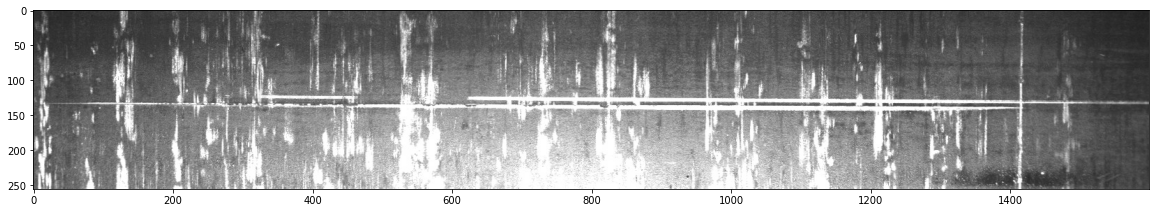

In [ ]:
img = Image.open(train_data + name)
plt.imshow(img)
plt.rcParams ['figure.figsize'] = [20, 50]
plt.show()

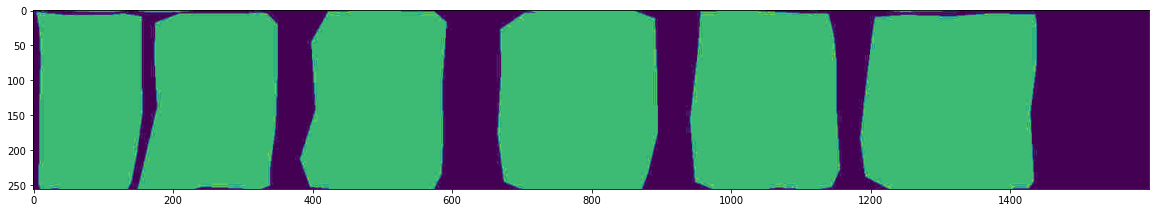

In [ ]:
img = get_mask(name, df)
plt.imshow(img)
plt.rcParams ['figure.figsize'] = [20, 50]
plt.show()

### Разделение на обучающую и тестовую выборки

Так как распределение классов дефектов несбалансированы, будет делать разные обучающие выборки для классификатора и модели сегментации. В тестовую выборку отберем изображения 20% изображенией с сохранением распределения по классам и количеству дефектов на изображении 

In [ ]:
count_to_img = df.ImageId.value_counts()
test_seg = [] #тестовая выборка для задачи сегментации
test_seg.append('db4867ee8.jpg') #добавим изображения с тремя дефектами
test_seg.extend(count_to_img[count_to_img==2][:85].index.values) #добавим изображения с двумя дефектами

In [ ]:
#посмотрим какое получилось распределение по класам дефектов
df.loc[df.ImageId.isin(test_seg)].ClassId.value_counts()

3    78
4    58
1    25
2    12
Name: ClassId, dtype: int64

In [ ]:
# train_test_split решил не использовать, чтобы лучше сохранить распределение
# df_to_split = df.loc[~df.ImageId.isin(test_seg)]
# x_train, x_test, y_train, y_test = train_test_split(df_to_split, df_to_split.ClassId, stratify=df_to_split.ClassId.values, test_size=0.15)

In [ ]:
df_to_split = df.loc[~df.ImageId.isin(test_seg)] #отберем изображения, которых еще нет в тестовой выборке
#добавим недостающее количество изображений в выборку
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 1, 'ImageId'][:153].values)
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 2, 'ImageId'][:36].values)
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 3, 'ImageId'][:951].values)
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 4, 'ImageId'][:102].values)

#создадим тестовую выборку для классификатора
test=test_seg.copy()
test.extend(df_to_split.loc[df_to_split.ClassId == 0, 'ImageId'][:1180].values)


In [ ]:
df_to_seg = df.loc[~df.ImageId.isin(test)] #убираем из набора данных тестовые изображения 

df_to_seg.drop(df_to_seg.loc[df_to_seg.ClassId == 3].index[:3331], axis=0, inplace=True) #делаем undersampling
df_to_seg.drop(df_to_seg.loc[df_to_seg.ClassId == 0].index[:], axis=0, inplace=True) #убираем изображения без дефектов

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#отбираем названия изображений для обучающей выборки модели сегментации
train_seg = df_to_seg.loc[~df_to_seg.ImageId.isin(test), 'ImageId'].values

In [ ]:
#посмотрим на распределение классов в обучающей выборке
df.loc[df.ImageId.isin(train_seg)].ClassId.value_counts()

3    995
1    717
4    634
2    200
Name: ClassId, dtype: int64

In [ ]:
#отбираем названия изображений для обучающей выборки классификатора
train = df.loc[~df.ImageId.isin(test), 'ImageId'].values

In [ ]:
print('Обучающая выборка для сегментации: ', len(train_seg))
print('Тестовая выборка для сегментации: ', len(test_seg))
print('Обучающая выборка для классификатора: ', len(train))
print('Тестовая выборка для классификатора: ', len(test))

Обучающая выборка для сегментации:  2335
Тестовая выборка для сегментации:  1328
Обучающая выборка для классификатора:  10388
Тестовая выборка для классификатора:  2508


### Создание генератора данных

In [ ]:
#Функция принимает на вход изображение и маску и выполняет аугментацию изображения. Если seg=True, то аугментация выполняется и над маской
def augmentation(img, label, seg=True):
    #Поворот изображения с вероятностью 0.5
    rotate = random.random() < .5
    if rotate:
        angle = random.randint(-5,5) #получаем случайный угол поворота
        h, w = img.shape[:2]
        center = (int(w / 2), int(h / 2))
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 0.6)
        img = cv2.warpAffine(img, rotation_matrix, (w, h))
        if seg==True:
            label = cv2.warpAffine(label, rotation_matrix, (w, h))
    #Отзеркаливание по вертикале с вероятностью 0.5
    flip_h = random.random() < .5
    if flip_h:
        img = cv2.flip(img, 1)
        if seg==True:
            label = cv2.flip(label, 1)
    #Отзеркаливание по горизонтали с вероятностью 0.5
    flip_v = random.random() < .5
    if flip_v:
        img = cv2.flip(img, 0)
        if seg==True:
             label = cv2.flip(label, 0)
             
    return img, label  

In [ ]:
#Создаем словарь {Название изображения: наличие дефекта}
dict_label = dict()
for value in df.values:
  dict_label[value[0]] = value[3]

Создадим два генератора - для сегментации и классификации

In [ ]:
class DataGeneratorSeg(Sequence):
    
    def __init__(self, img_name, data, batch_size=8, shuffle=True, aug=True):
        'Initialization'
        self.img_name = img_name        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.aug = aug
        self.data = data
        self.on_epoch_end()

    def __len__(self):
        #Получаем количество эпох
        return int(np.floor(len(self.img_name) / self.batch_size))

    def __getitem__(self, index):        
        # Получаем индекса батча данных
        list_IDs_temp = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Получаем данные по индексу
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        #Обновляем и перемешиваем индексы в конце каждой эпохи 
        self.indexes = np.arange(len(self.img_name))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

  
    def __data_generation(self, list_IDs_temp):
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            #Загружаем данные и меняем размер изображений
            path_img = '/content/train_images/'+self.img_name[i]
            img = cv2.imread(path_img)/255
            img = cv2.resize(img, (512,256), cv2.INTER_AREA) 

            label = get_mask(self.img_name[i], self.data)
            label = cv2.resize(label, (512,256), cv2.INTER_AREA)            
            #Выполняем аугментацию для обучающей выборки
            if self.aug == True:
                img, label = augmentation(img, label)                   
            #Делаем One-Hot-Encoding маски
            labels = np.zeros((256,512,4))
            for i in range(4):
                labels[:,:,i] = (label==i+1).astype(np.int32, copy=False)
            #Добавляем в список
            batch_labels.append(labels)
            batch_imgs.append(img)
                   
        return np.array(batch_imgs), np.array(batch_labels)

In [ ]:
class DataGeneratorClf(Sequence):
    
    def __init__(self, img_name, dict_label, batch_size=8, shuffle=True, aug=True):
        'Initialization'
        self.img_name = img_name
        self.dict_label= dict_label
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.aug = aug
        self.on_epoch_end()

    def __len__(self):
        #Получаем количество эпох
        return int(np.floor(len(self.img_name) / self.batch_size))

    def __getitem__(self, index):
        # Получаем индекса батча данных
        list_IDs_temp = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Получаем данные по индексу
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        #Обновляем и перемешиваем индексы в конце каждой эпохи 
        self.indexes = np.arange(len(self.img_name))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

  
    def __data_generation(self, list_IDs_temp):
        batch_imgs = list()
        batch_labels = list()

        
        for i in list_IDs_temp:
            #Загружаем данные и меняем размер изображения
            path_img = '/content/train_images/'+self.img_name[i]
            img = cv2.imread(path_img)/255
            img = cv2.resize(img, (512,256), cv2.cv2.INTER_AREA) 
            # Получаем метку классификатора
            labels = self.dict_label[self.img_name[i]]
            #Выполняем аугментацию для обучающей выборки
            if self.aug == True:
                img, labels = augmentation(img, labels, seg=False)                           
            
            #Добавляем в список
            batch_labels.append(labels)
            batch_imgs.append(img)
                   
        return np.array(batch_imgs), np.array(batch_labels)

In [ ]:
#Создаем генераторы для обучающих и тестовых выборок
train_gen_seg = DataGeneratorSeg(train_seg, df)
test_gen_seg = DataGeneratorSeg(test_seg, df, aug=False)

train_gen_clf = DataGeneratorClf(train,dict_label)
test_gen_clf = DataGeneratorClf(test,dict_label, aug=False)

### Создание и обучение моделей

In [ ]:
#Задаем метрику и функцию потерь

# Функция считает степень пересечения настоящей и предсказанной маски
def dice_coef(true, pred):
  return (2 * K.sum(true*pred)+1) / (K.sum(true) + K.sum(pred)+1)

# Функция потерь составная
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + 0.25*(1-dice_coef(y_true, y_pred))

#### Классификатор

In [ ]:
#Загрузим готовую модель классификатора без верхушки (Более хорошего результата удалось достигнуть без предобученных весов)
from keras.applications.efficientnet import EfficientNetB1
model_ = EfficientNetB1(include_top=False, weights=None, classes=2, input_shape=(256,512,3))

In [ ]:
#Добавим требуемых выход модели
x = model_.output

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

clf = Model(model_.input, output)

In [ ]:
clf.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
# history = clf.fit(train_gen_clf, validation_data=test_gen_clf, epochs=20)

In [ ]:
# clf.save_weights('/content/drive/MyDrive/Северсталь/encoder.h5')
clf.load_weights('/content/drive/MyDrive/Северсталь/encoder.h5')

In [ ]:
#Функция выводит графики обучения модели
def plot_history(history, num_epoch):
  plt.figure(figsize=(18, 6))
  name = list(history.keys())
  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(history[name[i]])
    plt.plot(history[name[i+2]])
    plt.xlabel("Эпоха")
    plt.ylabel("{}".format(name[i]))
    plt.xticks(range(0,num_epoch, 5))
    plt.legend(['Обучающая выборка','Тестовая выборка'])
  plt.show()

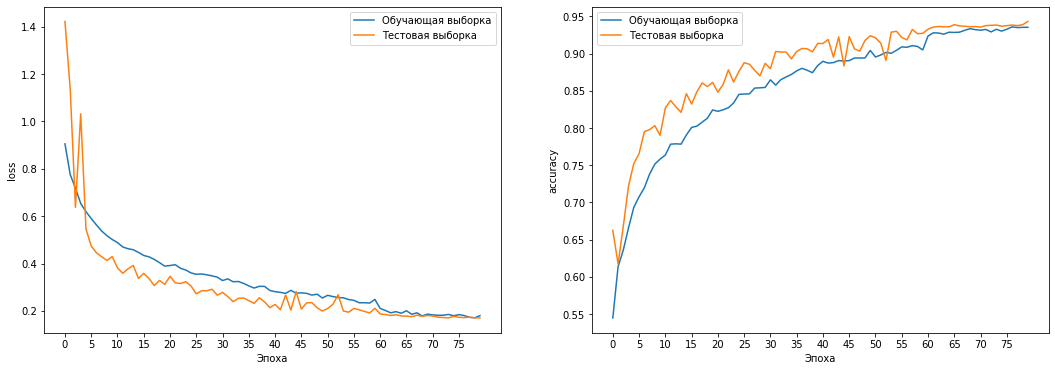

In [ ]:
plot_history(hist, 80)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.874276 to fit



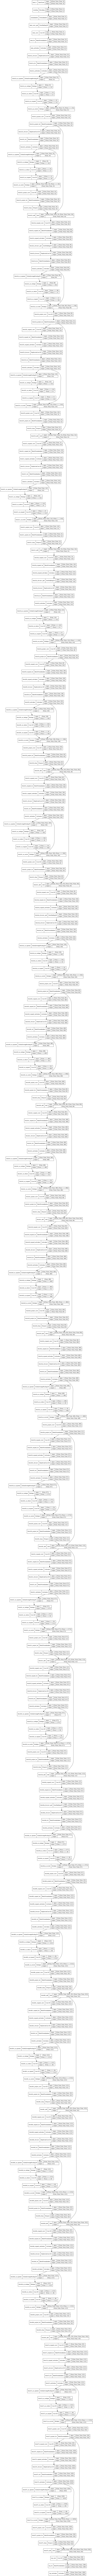

In [ ]:
#Посмотрим какие сли мы можем передать в модель сегментации
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
#Выведем нужные слои
for i in [31,75,119,236,338]:
    print(clf.layers[i].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 256, 96), dtype=tf.float32, name=None), name='block2a_expand_activation/IdentityN:0', description="created by layer 'block2a_expand_activation'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 128, 144), dtype=tf.float32, name=None), name='block3a_expand_activation/IdentityN:0', description="created by layer 'block3a_expand_activation'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 64, 240), dtype=tf.float32, name=None), name='block4a_expand_activation/IdentityN:0', description="created by layer 'block4a_expand_activation'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 32, 672), dtype=tf.float32, name=None), name='block6a_expand_activation/IdentityN:0', description="created by layer 'block6a_expand_activation'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 16, 1280), dtype=tf.float32, name=None), name='top_activation/IdentityN:0', description="created by layer 'top_activation'")


In [ ]:
#Создадим Unet модель сегментации с возможностью подавать данные сразу на декодер
def get_unet(clf):
  models={}

  models['encoder'] = Model(clf.input, [clf.layers[338].output, clf.layers[236].output, clf.layers[119].output, clf.layers[75].output, clf.layers[31].output])

  inp1 = Input((8, 16, 1280))
  inp2 = Input((16, 32, 672))
  inp3 = Input((32, 64, 240))
  inp4 = Input((64, 128, 144))
  inp5 = Input((128, 256, 96))

  #Функция делает промежуточные преобразования входных слоев
  def conv_input(input, filters):
    x = Conv2D(filters, (3,3), padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

  def decoder_layer(input, filters):     
    x = concatenate([input[0], input[1], input[2]])
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

  x2 = conv_input(inp2, 256)
  x3 = conv_input(inp3, 256)
  x4 = conv_input(inp4, 256)
  x5 = conv_input(inp5, 256)


  x = UpSampling2D()(inp1)  
  x = decoder_layer([x, inp2, x2], 256)
  x = UpSampling2D()(x)
  x = decoder_layer([x, inp3, x3], 128)
  x = UpSampling2D()(x)
  x = decoder_layer([x, inp4, x4], 64)
  x = UpSampling2D()(x) 
  x = decoder_layer([x, inp5, x5], 32)
  x = UpSampling2D()(x)
  x = Conv2D(16, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  output = Conv2D(4, (3,3), activation='sigmoid', padding='same')(x)  

  models['decoder'] = Model([inp1,inp2,inp3,inp4,inp5], output)

  models['unet'] = Model(clf.input, models['decoder'](models['encoder'](clf.input)))

  return models

In [ ]:
#Замораживаем слои классификатора
for layer in clf.layers:
    layer.trainable = False

In [ ]:
#Создаем модель сегментации на основе классификатора
models = get_unet(clf)
unet = models['unet']

In [ ]:
#Обучаем модель
unet.compile(optimizer=Adam(0.001), loss=bce_dice_loss, metrics=[dice_coef])
# history = unet.fit(train_gen_seg, validation_data=test_gen_seg, epochs=20)

In [ ]:
# unet.save_weights('/content/drive/MyDrive/Северсталь/unet_v2.h5')
unet.load_weights('/content/drive/MyDrive/Северсталь/unet_v2.h5')

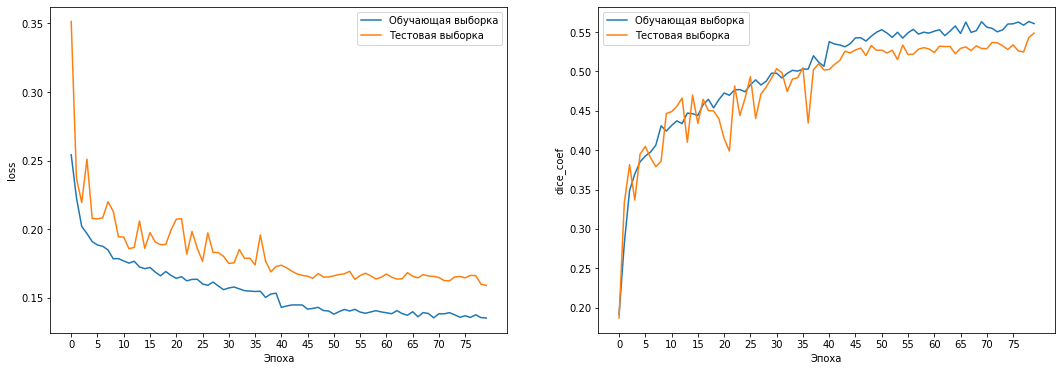

In [ ]:
plot_history(hist, 80)

In [ ]:
def get_predict(img):
  features_list = [clf.layers[i].output for i in [31,75,119,236,338,-1]]
  clf_backbone = Model(inputs=clf.input, outputs=features_list)
  encoder_pred = clf_backbone(img)

  if np.array(encoder_pred[-1][0][0]) > 0.5:
    inputs = encoder_pred[:-1]
    decoder = models['decoder']
    seg_pred = decoder.predict(inputs[::-1])
    pred_mask = (seg_pred[0] > 0.5).astype(np.int32)
    pred_mask = pred_mask[:,:,0] + pred_mask[:,:,1]*2+ pred_mask[:,:,2]*3+ pred_mask[:,:,3]*4
    pred_mask = pred_mask.astype(np.float32)
    pred_mask = cv2.resize(pred_mask, (1600,256), cv2.INTER_NEAREST)
    pred_mask[(pred_mask != 1) & (pred_mask != 2) & (pred_mask != 3) & (pred_mask != 4)] = 0 

  else: pred_mask = np.zeros((256,1600))

  return pred_mask


In [ ]:
def plot_predict(list_name, length=2508):
  n = random.randint(0, length)
  name = list_name[n]

  path_img = '/content/train_images/' + name
  mask = get_mask(name, df)

  orig_img = cv2.imread(path_img)/255
  img = cv2.resize(orig_img, (512,256), cv2.INTER_NEAREST) 
  img = img.reshape(1,256,512,3)

  pred_mask = get_predict(img)


  plt.figure(figsize=(30, 15))
  plt.subplot(3,1,1)
  plt.imshow(orig_img)
  plt.title('Оригинальное изображение')
  plt.subplot(3,1,2)
  plt.imshow(mask*60, cmap='jet')
  plt.title('Настоящая маска')
  plt.subplot(3,1,3)
  plt.imshow(pred_mask*60, cmap='jet')
  plt.title('Предсказаная маска')

  plt.show()
  

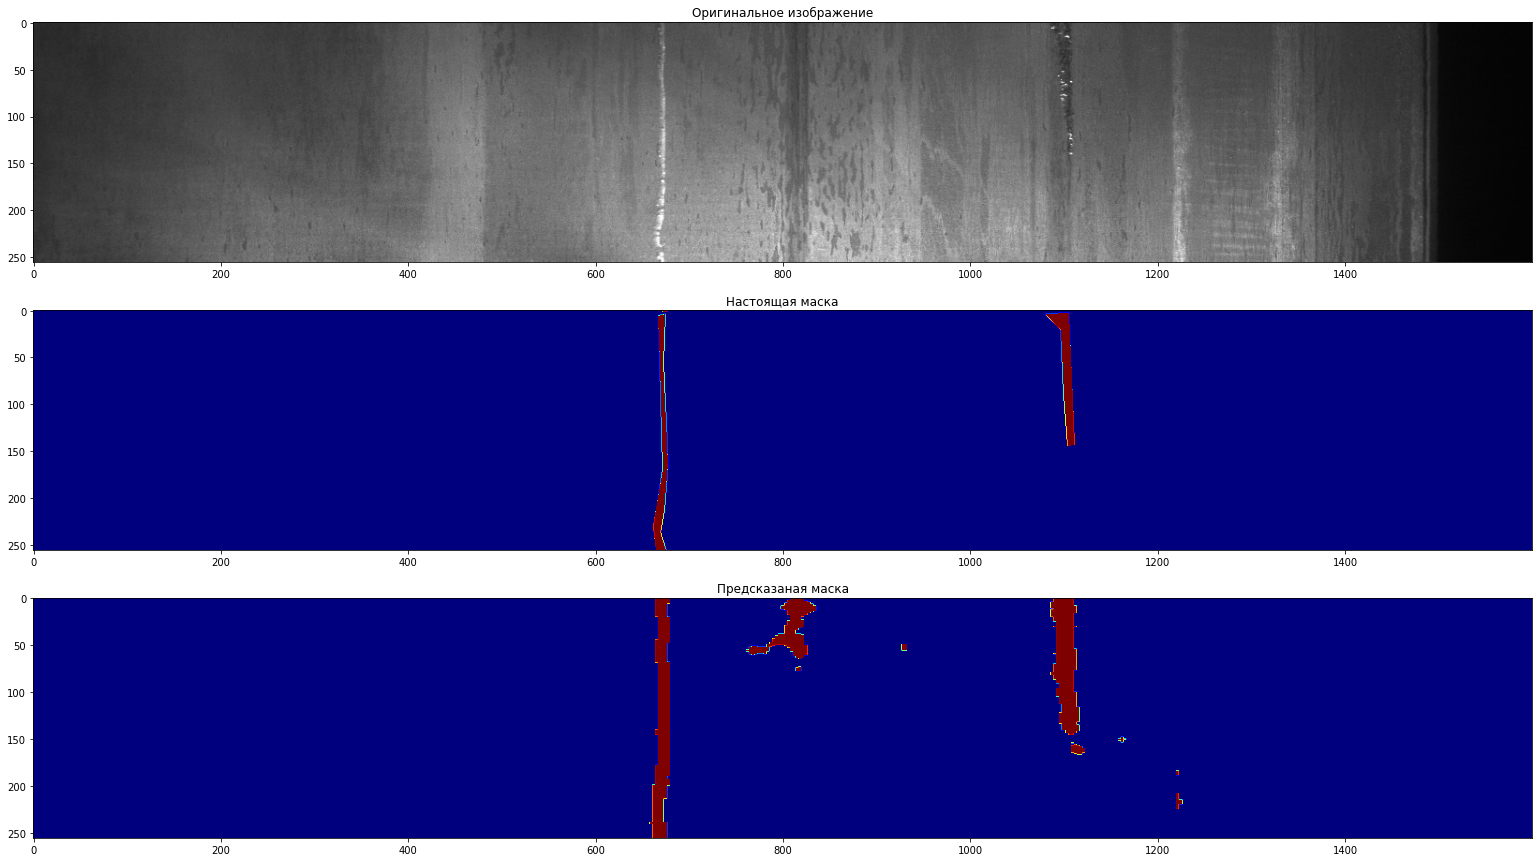

In [ ]:
plot_predict(test_seg, 1000)

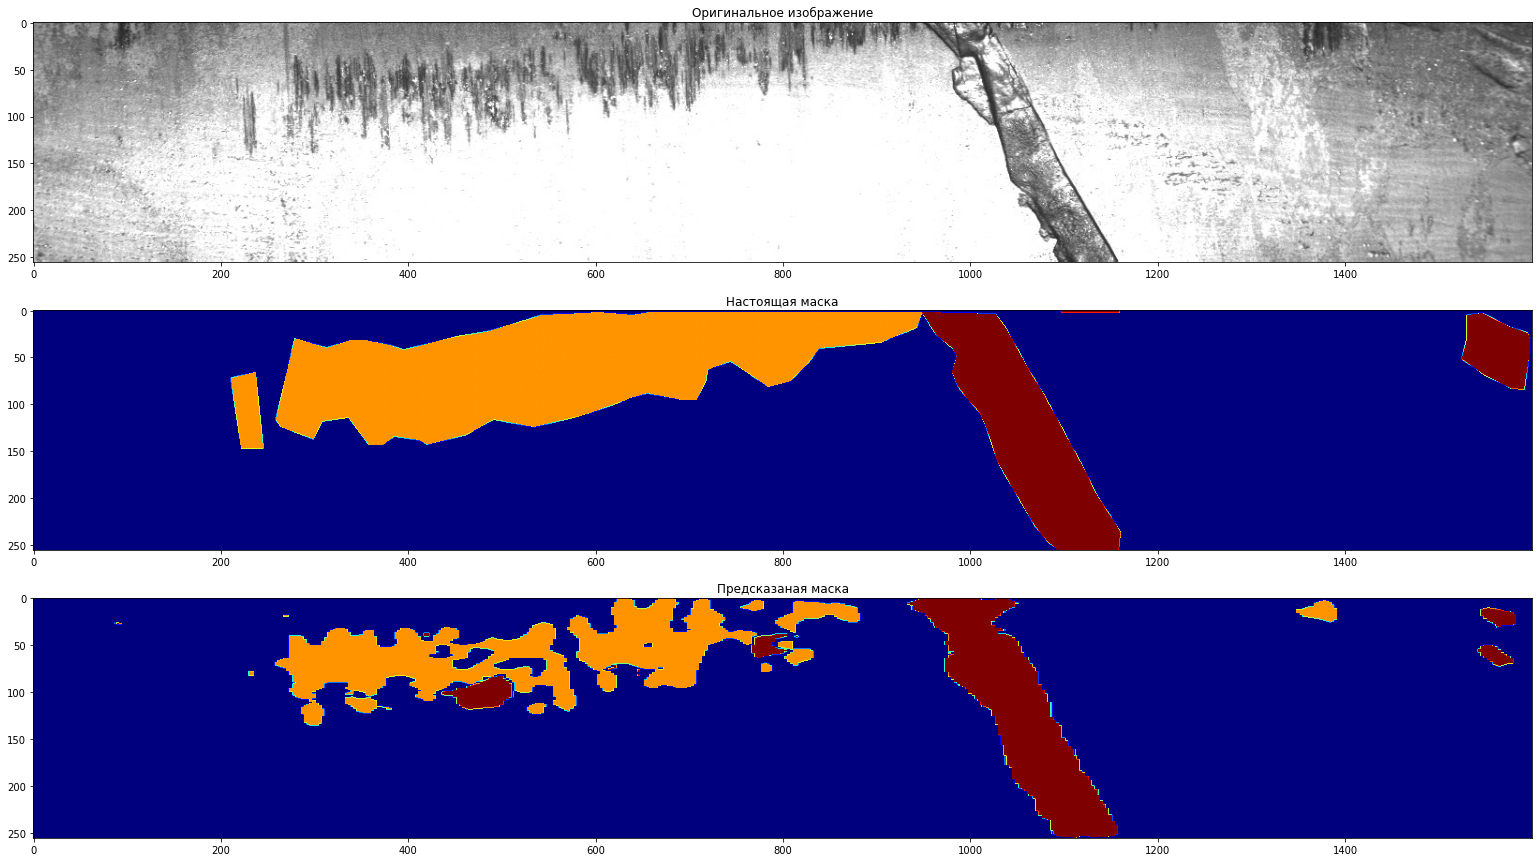

In [ ]:
#Изображение с двумя дефектами
plot_predict(test_seg, 80)

### Предобученная модель сегментации

In [ ]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 7.4 MB/s 


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet(backbone_name='efficientnetb1', classes=4, encoder_weights='imagenet', encoder_freeze=True)


27172864/27164032 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(0.001), loss=bce_dice_loss, metrics=[dice_coef])
history = model.fit(train_gen_seg, validation_data=test_gen_seg, epochs=10)

Epoch 1/10
292/292 [==============================] - 103s 320ms/step - loss: 0.1144 - dice_coef: 0.6317 - val_loss: 0.1265 - val_dice_coef: 0.6399
Epoch 2/10
292/292 [==============================] - 92s 316ms/step - loss: 0.1110 - dice_coef: 0.6430 - val_loss: 0.1233 - val_dice_coef: 0.6485
Epoch 3/10
292/292 [==============================] - 92s 313ms/step - loss: 0.1107 - dice_coef: 0.6444 - val_loss: 0.1205 - val_dice_coef: 0.6580
Epoch 4/10
292/292 [==============================] - 91s 313ms/step - loss: 0.1110 - dice_coef: 0.6422 - val_loss: 0.1210 - val_dice_coef: 0.6529
Epoch 5/10
292/292 [==============================] - 91s 312ms/step - loss: 0.1097 - dice_coef: 0.6471 - val_loss: 0.1203 - val_dice_coef: 0.6566
Epoch 6/10
292/292 [==============================] - 91s 312ms/step - loss: 0.1092 - dice_coef: 0.6465 - val_loss: 0.1205 - val_dice_coef: 0.6577
Epoch 7/10
292/292 [==============================] - 92s 314ms/step - loss: 0.1107 - dice_coef: 0.6422 - val_loss: 0

In [ ]:
# model.save_weights('/content/drive/MyDrive/Северсталь/unet_v3.h5')
model.load_weights('/content/drive/MyDrive/Северсталь/unet_v3.h5')

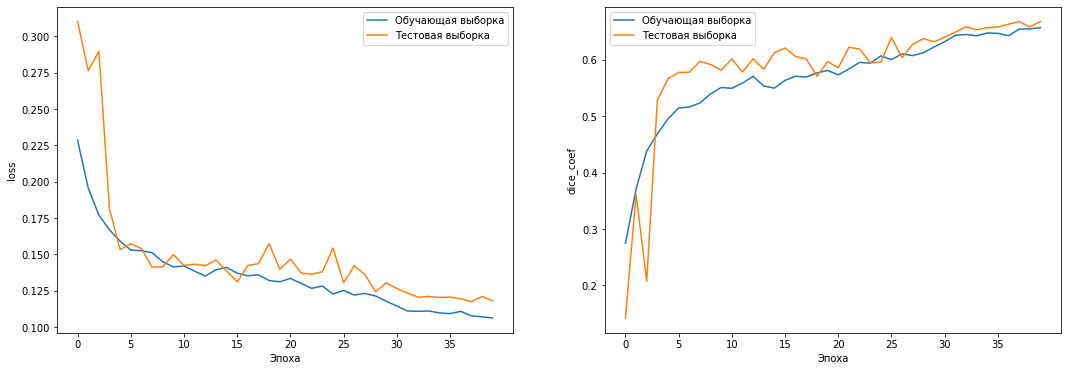

In [ ]:
plot_history(hist, 40)

In [ ]:
def get_predict(img):

  encoder_pred = clf.predict(img)
  if np.array(encoder_pred[0][0]) > 0.5:
    seg_pred = model.predict(img)
    pred_mask = (seg_pred[0] > 0.5).astype(np.int32)
    pred_mask = pred_mask[:,:,0] + pred_mask[:,:,1]*2+ pred_mask[:,:,2]*3+ pred_mask[:,:,3]*4
    pred_mask = pred_mask.astype(np.float32)
    pred_mask = cv2.resize(pred_mask, (1600,256), cv2.INTER_NEAREST)
    pred_mask[(pred_mask != 1) & (pred_mask != 2) & (pred_mask != 3) & (pred_mask != 4)] = 0 

  else: pred_mask = np.zeros((256,1600))

  return pred_mask


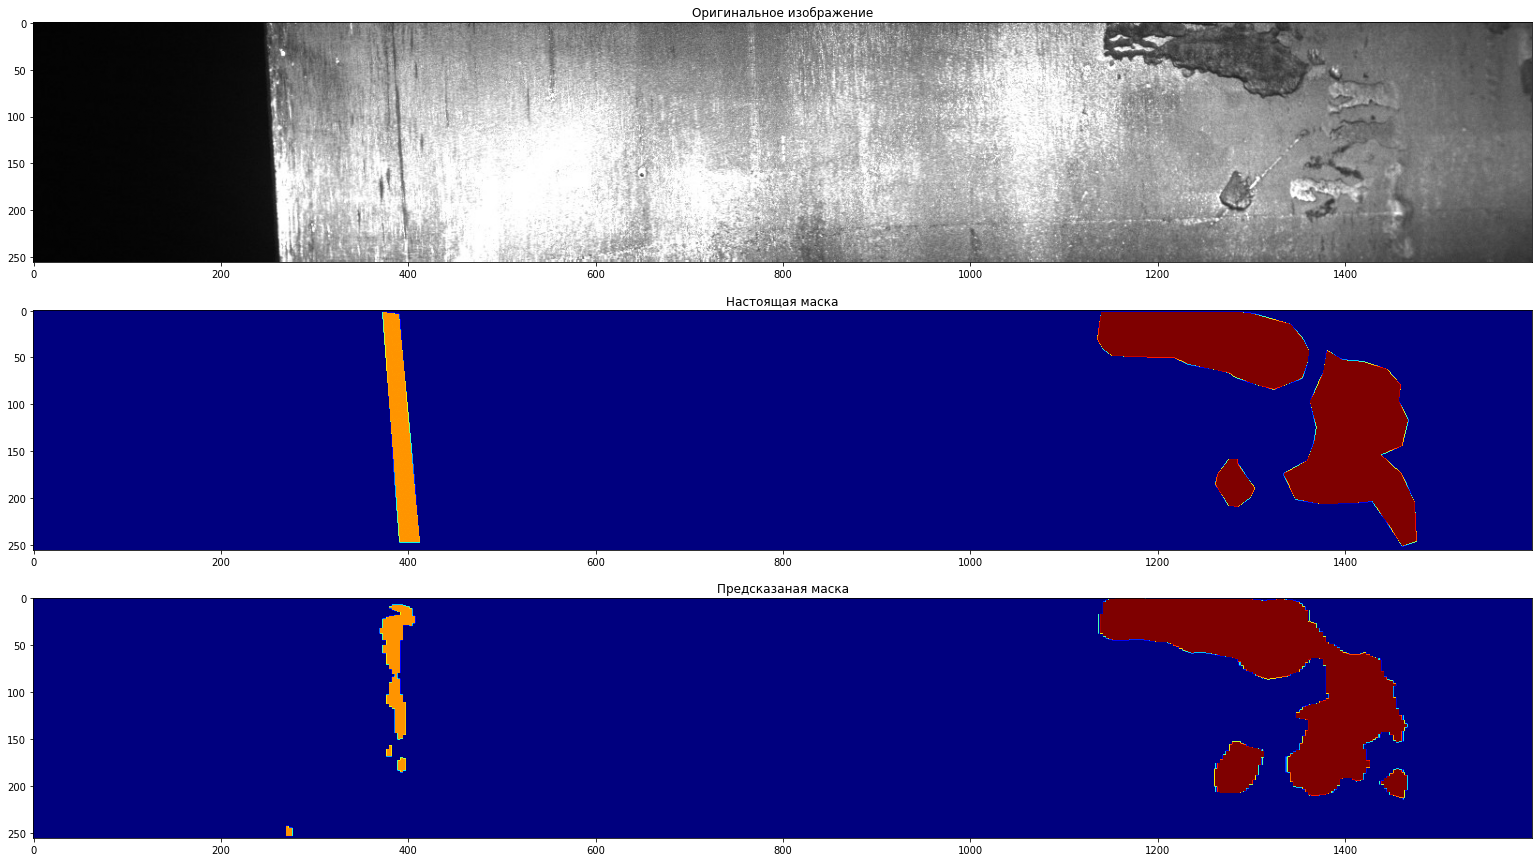

CPU times: user 933 ms, sys: 19.6 ms, total: 952 ms
Wall time: 934 ms


In [ ]:
%%time
plot_predict(test_seg, 80)

Итог: 

мое предположение, что можно ускорить работу, передав выходы со слоев классификатора на модель сегментации, не оправдалось. Две последовательные модели работают быстрее и показывают лучшее качество